In [173]:
import os
import ast
from collections import defaultdict, Counter
import boto3
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from learning_utils import pickle_load
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline

In [174]:
def cohend(l1, l2):
    pooled_std = np.sqrt(((np.std(l1)**2) + np.std(l2)**2)/2)
    return (np.mean(l1) - np.mean(l2))/pooled_std

In [175]:
dists = []
for i in range(43):
    dists += pickle_load(f"bias_dists/t_dist_{i}.pkl")
dists = [tuple(d) for d in dists]

In [176]:
def get_id(conds):
    return [cond//3 for cond in conds]

def get_dists(conds):
    sda = Counter([dist_map[dists[cond]] for cond in conds])
    non_risky_count = sum([sda[i] for i in range(4)])
    risky_count = sum([sda[i] for i in range(4, 10)])
    return {'risky': risky_count, 'non_risky': non_risky_count}

dist_count = Counter(dists)
dist_map = {}
reverse_dist_map = {}
for i, dist in enumerate(dist_count.keys()):
    dist_map[dist] = i
    reverse_dist_map[i] = dist
    
risk_map = {}
ps = []
for d in dist_map.keys():
    t = sum(d[:2] + d[-2:])
    ps.append(t)
    
cutoff_val = 0.05#np.mean(ps)#0.05#np.mean(ps)

for d in dist_map.keys():
    t = sum(d[:2] + d[-2:])
    if t>=cutoff_val:
        risk_map[d] = 1
    else:
        risk_map[d] = 0

In [177]:
dist_types = [dist_map[d] for d in dists]
print(dist_types)
dist_type_lists = defaultdict(list)
for i, dt in enumerate(dist_types):
    dist_type_lists[dt].append(i)

np.random.seed(1234)
total_res = []
for d in dist_type_lists.keys():
    bs = np.random.choice(dist_type_lists[d], 2, replace=False)
    print(bs)
    total_res += bs.tolist()
total_res = sorted(total_res)
print(total_res)
print([f"{b//2}_{b%2}" for b in total_res])

[0, 1, 2, 0, 3, 4, 0, 5, 6, 3, 7, 1, 5, 8, 0, 2, 4, 1, 2, 4, 6, 2, 8, 1, 3, 5, 2, 1, 0, 1, 8, 4, 2, 0, 6, 1, 7, 8, 6, 2, 0, 4, 5, 1, 4, 5, 1, 5, 1, 3, 0, 5, 7, 6, 7, 1, 3, 1, 4, 2, 1, 4, 7, 5, 4, 6, 4, 0, 0, 6, 8, 0, 5, 0, 0, 3, 4, 8, 1, 2, 6, 5, 1, 2, 4, 8]
[71  0]
[57 82]
[59 32]
[56 75]
[58 66]
[81 25]
[34 38]
[36 52]
[77 85]
[0, 25, 32, 34, 36, 38, 52, 56, 57, 58, 59, 66, 71, 75, 77, 81, 82, 85]
['0_0', '12_1', '16_0', '17_0', '18_0', '19_0', '26_0', '28_0', '28_1', '29_0', '29_1', '33_0', '35_1', '37_1', '38_1', '40_1', '41_0', '42_1']


In [329]:
# Get data
error_ids = []
def read_file(filename):
    f = open(filename)
    l = f.read().splitlines()
    return l

def filter_data(e_data, hits):
    e_data = e_data[e_data.hitid.isin(hits)]
    e_data = e_data[e_data.status.isin([4, 5, 7])]
    return e_data

def get_datastring(row):
    return json.loads(row.datastring)

def parse_data(data):
    data['datastring'] = data.apply(get_datastring, axis=1)
    return data

def extract_condition(row):
    return row["datastring"]["condition"]

def extract_condition_risky_choice(row):
    return row.datastring["questiondata"]["condition"]

def is_risky(row):
    return risk_map[dists[row.cond // 3]]

def extract_age(row):
    age = np.nan
    check = True
    for t_data in row.datastring["data"]:
        if "trial_type" in t_data["trialdata"]:
            if t_data["trialdata"]["trial_type"] == "survey-html-form":
                d = ast.literal_eval(t_data["trialdata"]["responses"])
                #print(d)
                age = int(d["age"])
                check = False
    if check:
        error_ids.append(row.workerid)
    return age

def extract_gender(row):
    gender = np.nan
    check = True
    for t_data in row.datastring["data"]:
        if "trial_type" in t_data["trialdata"]:
            if t_data["trialdata"]["trial_type"] == "survey-html-form":
                d = ast.literal_eval(t_data["trialdata"]["responses"])
                #print(d)
                gender = d["gender"]
                check = False
    if check:
        error_ids.append(row.workerid) #This data was only asked in the end and if check is true exp has not been completed. Upon further verification, we found that they didn't pass the comprehension 
    return gender

max_index = 10 #To have same comparison across conditions
def extract_trial_data(df):
    p_scores = []
    p_num_clicks = []
    average_clicks = []
    average_scores = []
    p_max_probs = []
    p_max_evs = []
    p_all_evs = []
    p_max_ev_poss = []
    p_rank_evs = []
    tt = []
    p_payoff_matrices = []
    p_probs = []
    p_ev_scores = []
    p_clicks = []
    for i, d in df.iterrows():
        scores = []
        max_probs = []
        max_ev = []
        all_evs = []
        max_ev_poss = []
        rank_evs = []
        probs = []
        ev_scores = []
        clicks = []
        payoff_matrices = []
        dat = d["datastring"]["data"]
        index = 0
        t_c = []
        for k in dat:
            z = k["trialdata"]
            if "trial_id" in z and index<max_index:
                if "test_" in z["trial_id"]:
                    payoff_tuples = tuple([tuple(p) for p in z["payoff_matrix"]])
                    #tt.append((tuple(z["probabilities"]), payoff_tuples))
                    tt.append(tuple(z["probabilities"]))
                    scores.append(z["net_payoff"])
                    num_clicks = len(z["clicks"])
                    t_c.append(num_clicks)
                    ev = np.dot((np.array(z["payoff_matrix"]).T)[z["choice_index"]], z["probabilities"])
                    all_ev = np.dot(np.array(z["payoff_matrix"]).T, z["probabilities"])
                    all_evs.append(all_ev)
                    rank_evs.append(np.argsort(all_ev)[::-1].tolist()[z["choice_index"]])
                    max_ev_pos = np.argmax(all_ev)
                    max_ev_poss.append(max_ev_pos)
                    ev_scores.append(ev - z["click_cost"])
                    max_probs.append(np.max(z['probabilities']))
                    max_i = np.argmax(np.dot(z["probabilities"], np.array(z["payoff_matrix"])))
                    max_ev.append(np.dot((np.array(z["payoff_matrix"]).T)[max_i], z["probabilities"]))
                    index += 1
                    payoff_matrices.append(z["payoff_matrix"])
                    probs.append(z["probabilities"])
                    clicks.append(z["clicks"])
        if t_c:
            average_clicks.append(np.mean(t_c))
            average_scores.append(np.mean(scores))
        else:
            average_clicks.append(0)
            average_scores.append(0)
        
        p_probs.append(probs)
        p_num_clicks.append(t_c)
        p_clicks.append(clicks)
        p_payoff_matrices.append(payoff_matrices)
        p_scores.append(np.array(scores))
        p_max_evs.append(max_ev)
        p_max_probs.append(max_probs)
        p_all_evs.append(all_evs)
        p_max_ev_poss.append(max_ev_poss)
        p_rank_evs.append(rank_evs)
        p_ev_scores.append(ev_scores)
        
    df['scores'] = p_scores
    df['num_clicks'] = p_num_clicks
    df['average_clicks'] = average_clicks
    df['average_score'] = average_scores
    df['max_probs'] = p_max_probs
    df['max_evs'] = p_max_evs
    df['max_ev_pos'] = p_max_ev_poss
    df['all_evs'] = p_all_evs
    df['rank_evs'] = p_rank_evs
    df['clicks'] = p_clicks
    df['payoff_matrices'] = p_payoff_matrices
    df['probs'] = p_probs
    df['ev_scores'] = p_ev_scores
    df['av_ev'] = [np.mean(s) for s in p_ev_scores]
    return df

def remove_inattentive_participants(df):
    ind_to_remove = []
    for i, d in df.iterrows():
        trial_actions = d['trial_actions']
        len_trials = [len(actions) for actions in trial_actions]
        counts = Counter(len_trials)
        if counts[1] > len(trial_actions)/2:
            ind_to_remove.append(i)
    df.drop(ind_to_remove, inplace=True)
    return df

def add_l(L):
    temp = []
    L = L.tolist()
    if isinstance(L[0], float):
        return L
    else:
        for l in L:
            temp += l
        return temp
    
def make_long_format(df):
    worker_ids = df.workerid.tolist()
    new_data = []
    for i, wid in enumerate(worker_ids):
        m_df = df[df.workerid == wid]
        env = m_df.env.tolist()[0]
        scores = m_df.scores.tolist()[0]
        ev_scores = m_df.ev_scores.tolist()[0]
        max_probs = m_df.max_probs.tolist()[0]
        max_evs = m_df.max_evs.tolist()[0]
        condition = m_df.condition.tolist()[0]
        max_ev_poss = m_df.max_ev_pos.tolist()[0]
        all_evs = m_df.all_evs.tolist()[0]
        rank_evs = m_df.rank_evs.tolist()[0]
        risk = m_df.risky.tolist()[0]
        clicks = m_df.clicks.tolist()[0]
        payoff_matrices = m_df.payoff_matrices.tolist()[0]
        probs = m_df.probs.tolist()[0]
        other_cols = ['ev_' + str(i) for i in range(len(all_evs[0]))]
        for trial_id, score in enumerate(scores):
            new_data.append([i, trial_id, env, condition, score, max_probs[trial_id], max_evs[trial_id], max_ev_poss[trial_id], rank_evs[trial_id], payoff_matrices[trial_id], probs[trial_id], clicks[trial_id], risk, ev_scores[trial_id]] + all_evs[trial_id].tolist())
    new_df = pd.DataFrame(new_data, columns = ['pid', 'trial_id', 'environment', 'condition', 'score', 'max_prob', 'max_ev', 'max_ev_pos', 'rank_ev', 'payoff_matrix', 'probs', 'clicks', 'risky', 'ev_score'] + other_cols)
    return new_df

In [330]:
exps = ["riskychoice_main_high_1", "riskychoice_main_high_2"]
#exps = ["riskychoice_pilot4_high_1", "riskychoice_pilot4_high_2"]
envs = ["high_1", "high_2"]
def get_data(exps):
    complete_data = []
    for i, exp_name in enumerate(exps):
        print(exp_name)
        hit_ids = read_file(f"exp_data/{exp_name}.txt")
        data = pd.read_csv(f"exp_data/{exp_name}.csv")
        cr_data = pd.read_csv(f"exp_data/{exp_name}cr.csv")
        data = filter_data(data, hit_ids)
        data = data[~data.endhit.isnull()]
        data2 = data[['beginhit', 'endhit', 'datastring']]
        worker_ids = set(data['workerid'].values)
        cr_worker_ids = set(cr_data['AmazonIdentifier'].values) # Get this list from cloudresearch
        data = data[data.workerid.isin(cr_worker_ids)]
        data = parse_data(data)
        data['condition'] = data.apply(extract_condition_risky_choice, axis=1)
        data['age'] = data.apply(extract_age, axis=1)
        #print(np.nanmean(data['age']))
        #print(np.min(data['age']), np.max(data['age']))
        data['gender'] = data.apply(extract_gender, axis=1)
        #print(Counter(data['gender']))
        data['env'] = envs[i]
        data['risky'] = data.apply(is_risky, axis=1)
        data['beginhit'] = data['beginhit'].astype('datetime64[ns]') 
        data['endhit'] = data['endhit'].astype('datetime64[ns]')
        data['timediff'] = (data['endhit'] - data['beginhit']).dt.total_seconds()
        #print(np.nanmean(data['timediff']))
        data = extract_trial_data(data)
        data = data[~(data.scores.str.len() == 0)]
        complete_data.append(data)
        print(len(data))
    complete_data = pd.concat(complete_data)
    return complete_data
data = get_data(exps)
long_df = make_long_format(data)
long_df.to_csv("riskychoice.csv", float_format='%.2f')

riskychoice_main_high_1


/Users/yjain/anaconda3/envs/cogtut/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/yjain/anaconda3/envs/cogtut/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


246
riskychoice_main_high_2
234


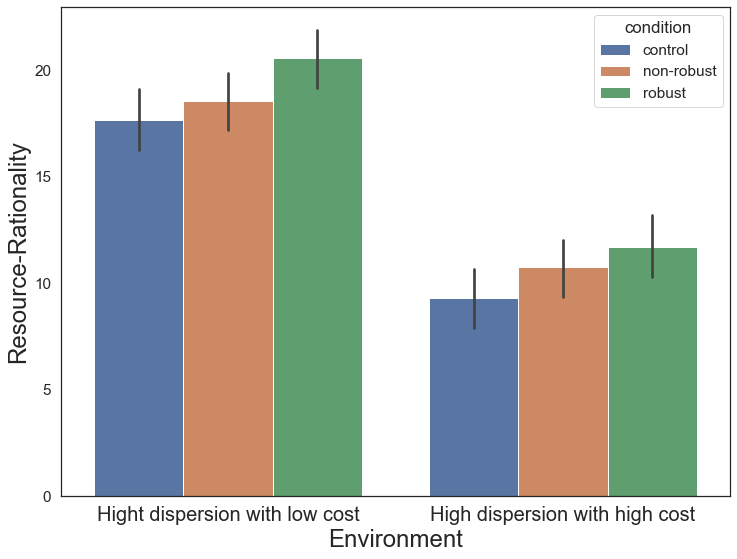

In [338]:
#long_df.groupby(['environment', 'condition'])['score'].mean()
import seaborn as sns
d2 = long_df.copy()
d2['condition'] = d2['condition'].apply(lambda x: {0:'control' , 1:'non-robust', 2:'robust'}[x])
d2['environment'] = d2['environment'].apply(lambda x: {'high_1':'Hight dispersion with low cost' , 'high_2': 'High dispersion with high cost'}[x])
d2 = d2.rename(columns={'ev_score': 'Resource-Rationality', 'environment': 'Environment'})
d2.sort_values('condition', inplace=True)
plt.figure(figsize=(12, 9))
p = sns.barplot(x='Environment', hue='condition', y='Resource-Rationality', data=d2)
p.set_xlabel("Environment", fontsize = 24)
p.set_ylabel("Resource-Rationality", fontsize = 24)
p.set_xticklabels(["Hight dispersion with low cost", "High dispersion with high cost"], size = 20)
plt.savefig("bar_plot.pdf", bbox_inches='tight')



In [333]:
print(len(data.probs), len(data.clicks))

480 480


In [335]:
from statsmodels.formula.api import ols
long_df['control'] = (long_df.condition == 0)
long_df['non_robust'] = (long_df.condition == 1)
long_df['robust'] = (long_df.condition == 2)
long_df['high_2'] = (long_df.environment == 'high_2')
model = ols('ev_score ~ non_robust + robust + high_2 + non_robust:high_2 + robust:high_2', data=long_df).fit()
import statsmodels
statsmodels.stats.anova.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
non_robust,1.107986e+03,1.0,2.699471,1.004471e-01
robust,5.500393e+03,1.0,13.401024,2.541952e-04
high_2,8.270637e+04,1.0,201.503783,7.856007e-45
non_robust:high_2,6.892722e+01,1.0,0.167933,6.819740e-01
robust:high_2,5.504451e+01,1.0,0.134109,7.142252e-01
Residual,1.967677e+06,4794.0,NaN,NaN


In [336]:
df2 = long_df[~(long_df.condition == 0)]
model = ols('ev_score ~ high_2 + robust + robust:high_2', data=df2).fit()
import statsmodels
statsmodels.stats.anova.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
high_2,5.477154e+04,1.0,135.522464,1.052360e-30
robust,1.733077e+03,1.0,4.288192,3.845830e-02
robust:high_2,2.456634e+02,1.0,0.607851,4.356562e-01
Residual,1.287625e+06,3186.0,NaN,NaN


In [337]:
import itertools
dd = []
for p, c, cond, scores, ev_scores in zip(data.probs, data.clicks, data.condition, data.scores, data.ev_scores):
    for pp, cc, score, ev_score in zip(p, c, scores, ev_scores):
        #print(max(pp), cc)
        std_probs = np.std(pp)
        dd.append([max(pp), sum([1 if k in [0, 1, 2, 3] else 0 for k in cc ]), cond, score, ev_score, std_probs])
dd_df = pd.DataFrame(dd, columns=['max_prob', 'count', 'condition', 'score', 'ev_score', 'std_probs'])
#dd_df['prob_high'] = dd_df.max_prob > 0.5
dd_df['control'] = (dd_df.condition == 0)
dd_df['non_robust'] = (dd_df.condition == 1)
dd_df = dd_df[~(dd_df.condition==0)]
dd_df['std_d'] = pd.qcut(dd_df['std_probs'], 4, labels=False)
dd_df.drop(['max_prob', 'std_probs'], inplace=True, axis=1)
display(dd_df.describe())
display(dd_df)

,count,condition,score,ev_score,std_d
count,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000
mean,2.264890,1.482759,15.220063,15.446458,1.484013
std,1.411458,0.499781,25.694221,20.532669,1.104267
min,0.000000,1.000000,-109.000000,-95.500000,0.000000
25%,1.000000,1.000000,3.000000,4.210000,0.250000
50%,3.000000,1.000000,15.000000,13.900000,1.000000
75%,3.000000,2.000000,29.000000,26.647500,2.000000
max,4.000000,2.000000,98.000000,92.150000,3.000000


,count,condition,score,ev_score,control,non_robust,std_d
10,2,2,1,1.00,False,False,3
11,3,2,8,6.55,False,False,2
12,3,2,28,28.00,False,False,3
13,2,2,30,22.89,False,False,2
14,3,2,30,27.23,False,False,2
...,...,...,...,...,...,...,...
4775,1,2,11,6.32,False,False,2
4776,4,2,41,7.51,False,False,0
4777,3,2,35,35.00,False,False,3
4778,4,2,-18,13.20,False,False,0


count      score   ev_score control non_robust
                     mean       mean       mean    mean       mean
condition std_d                                                   
1         0      2.315036  10.436754  10.608329     0.0        1.0
          1      2.110312  11.350120  12.271223     0.0        1.0
          2      1.993103  16.227586  16.829540     0.0        1.0
          3      1.970976  19.424802  19.533351     0.0        1.0
2         0      2.720317  10.598945   9.455989     0.0        0.0
          1      2.419948  14.044619  15.213622     0.0        0.0
          2      2.386861  18.340633  17.824988     0.0        0.0
          3      2.241192  22.002710  22.444282     0.0        0.0

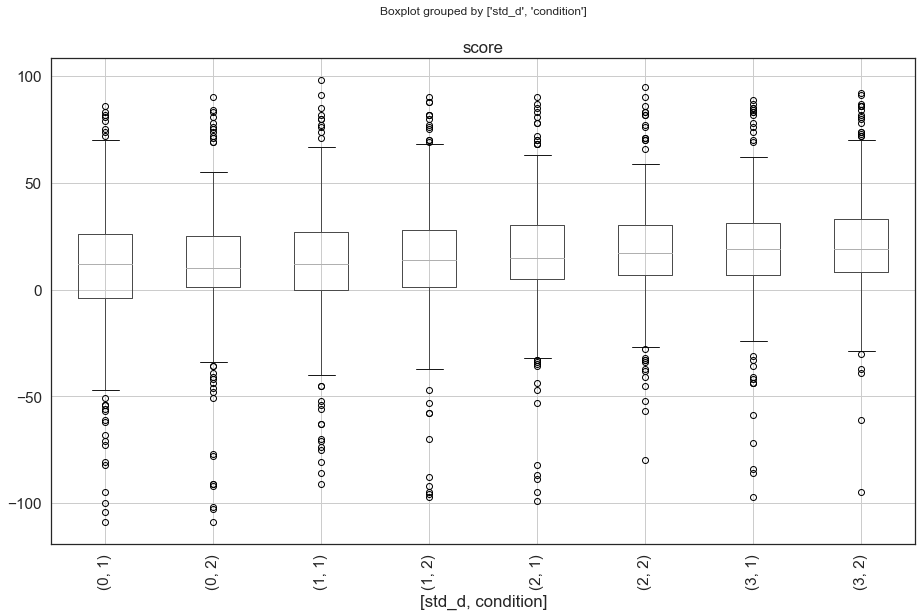

In [305]:
def se(x):
    return 1.96*np.std(x)/np.sqrt(len(x))
dd_df.dropna(inplace=True, axis=0)
dd_df.boxplot(column=['score'], by=['std_d', 'condition'], figsize=(15, 9), rot=90)
dd_df.groupby(['condition', 'std_d']).agg(['mean'])

In [306]:
st, p = mannwhitneyu(dd_df[dd_df.condition == 1]['count'], dd_df[dd_df.condition==2]['count'], alternative='less')
print(st, p)
print(np.median(dd_df[dd_df.condition == 1]['count']), np.median(dd_df[dd_df.condition == 2]['count']))

1125672.5 5.816987573355083e-09
2.0 3.0


In [307]:
for d in range(4):
    for s in range(4):
        print(s, d)
        d_df = dd_df.query(f'std_d == {s} & count=={d}')
        st, p = mannwhitneyu(d_df[d_df.condition == 1].score, d_df[d_df.condition==2].score, alternative='less')
        print(st, p)

0 0
1683.5 0.18607104056677576
1 0
1450.5 0.37130452697985544
2 0
1879.0 0.5902723129147629
3 0
1250.0 0.06718762749189654
0 1
387.0 0.6841075635005428
1 1
1292.5 0.04131179221289551
2 1
2408.5 0.5618862267131048
3 1
2297.5 0.7134368938155564
0 2
1837.5 0.31667113391762514
1 2
3189.5 0.8317592507208881
2 2
2969.0 0.15240848774788573
3 2
2745.0 0.6364457478002673
0 3
5947.5 0.8729744744791059
1 3
3933.0 0.06610492706444561
2 3
5705.0 0.3723642963926981
3 3
5527.0 0.4655622015376912


In [308]:
from statsmodels.formula.api import ols
#model = ols('score ~ std_d+control+non_robust+count',
              #data=dd_df)
model = smf.mixedlm('score~std_d+control+count', dd_df, groups=dd_df["non_robust"])
model_fit = model.fit()
print("Params:\n", model_fit.params, "\n")
print("Summary:\n", model_fit.summary())

LinAlgError: Singular matrix

In [ ]:
clicks = data[data.condition==0].clicks.tolist()
C = []
for c in clicks:
    for p in c:
        if len(p):
            C += p
count = Counter(C)
#sns.displot(C)
x = list(range(31))
plt.bar(x=x, height=[count[i] for i in x])

plt.figure()
clicks = data[data.condition==1].clicks.tolist()
C = []
for c in clicks:
    for p in c:
        if len(p):
            C += p
count = Counter(C)
#sns.displot(C)
x = list(range(31))
plt.bar(x=x, height=[count[i] for i in x])

plt.figure()
clicks = data[data.condition==2].clicks.tolist()
C = []
for c in clicks:
    for p in c:
        if len(p):
            C += p
count = Counter(C)
#sns.displot(C)
x = list(range(31))
plt.bar(x=x, height=[count[i] for i in x])

In [ ]:
ax = sns.histplot(long_df[long_df.condition == 1]['ev_score'], label='NR', color='blue')
ax=sns.histplot(long_df[long_df.condition == 0]['ev_score'], label='ND', color='red')
ax=sns.histplot(long_df[long_df.condition == 2]['ev_score'], label='R', ax=ax, color='green')
plt.legend()
plt.plot();

In [ ]:
display(long_df.groupby(['environment', 'condition'])['score'].describe()[['mean', 'std', '50%', 'count']])

In [ ]:
ev_scores = long_df.groupby('trial_id').mean()['ev_score']
scores = long_df.groupby('trial_id').mean()['score']
plt.figure(figsize=(15,9))
plt.plot(range(1, 11), scores, label='Score')
plt.plot(range(1, 11), ev_scores, label='EV Score')
plt.xlabel('Trial Number', fontsize=24)
plt.ylabel('Score', fontsize=24)
plt.legend()
plt.show()

### Condition wise analysis

In [ ]:
no_demo_df = data[data.condition == 0]
non_robust_df = data[data.condition == 1] 
robust_df = data[data.condition == 2]

In [309]:
conds = ['No demo', 'Non-robust', "Robust"]
cond_df = [no_demo_df, non_robust_df, robust_df]

In [310]:
ev_scores = [[s for s in d['ev_scores'].values] for d in cond_df]
scores = [[s for s in d['scores'].values] for d in cond_df]

t_mean_scores = [np.mean(k, axis=0) for k in scores]
t_mean_ev_scores = [np.mean(k, axis=0) for k in ev_scores]

t_med_scores = [np.median(k, axis=0) for k in scores]
t_med_ev_scores = [np.median(k, axis=0) for k in ev_scores]

p_mean_scores = [np.mean(k, axis=1) for k in scores]
p_mean_ev_scores = [np.mean(k, axis=1) for k in ev_scores]

p_med_scores = [np.median(k, axis=1) for k in scores]
p_med_ev_scores = [np.median(k, axis=1) for k in ev_scores]

### ANOVA

In [311]:
from scipy.stats import kruskal
types = ["Mean", "Mean EV", "Median", "Median EV"]
ds = [p_mean_scores, p_mean_ev_scores, p_med_scores, p_med_ev_scores]

for i, d in enumerate(ds):
    print(types[i])
    H, p = kruskal(*d)
    print(f"H-statistic: {np.round(H, 3)}, p-value: {np.round(p, 4)}")

Mean
H-statistic: 6.963, p-value: 0.0308
Mean EV
H-statistic: 6.783, p-value: 0.0337
Median
H-statistic: 3.193, p-value: 0.2026
Median EV
H-statistic: 2.071, p-value: 0.3551


### Test of normality

In [312]:
from scipy.stats import shapiro

for i, d in enumerate(ds):
    print(types[i])
    for k in range(3):
        print(conds[k])
        s, p = shapiro(d[k])
        if p <0.05:
            print("The distribution is not normal")
        print("dof:", len(d)-1)
        print("s=", np.round(s, 2), "p=", np.round(p, 4))
        print("")
    print("")

Mean
No demo
The distribution is not normal
dof: 2
s= 0.96 p= 0.0003

Non-robust
dof: 2
s= 0.99 p= 0.1694

Robust
The distribution is not normal
dof: 2
s= 0.91 p= 0.0


Mean EV
No demo
The distribution is not normal
dof: 2
s= 0.97 p= 0.001

Non-robust
The distribution is not normal
dof: 2
s= 0.98 p= 0.0107

Robust
The distribution is not normal
dof: 2
s= 0.91 p= 0.0


Median
No demo
The distribution is not normal
dof: 2
s= 0.98 p= 0.0053

Non-robust
The distribution is not normal
dof: 2
s= 0.98 p= 0.0268

Robust
The distribution is not normal
dof: 2
s= 0.92 p= 0.0


Median EV
No demo
The distribution is not normal
dof: 2
s= 0.98 p= 0.018

Non-robust
The distribution is not normal
dof: 2
s= 0.98 p= 0.0113

Robust
The distribution is not normal
dof: 2
s= 0.9 p= 0.0




In [313]:
from scipy.stats import mannwhitneyu

for i, d in enumerate(ds):
    print(types[i])
    # No-demo vs Non-robust
    st, p = mannwhitneyu(d[0], d[1], alternative='less')
    print(np.round(st, 2), np.round(p, 4))
    # No-demo vs Robust
    st, p = mannwhitneyu(d[0], d[2], alternative='less')
    print(np.round(st, 2), np.round(p, 4))
    # Non-robust vs Robust
    st, p = mannwhitneyu(d[1], d[2], alternative='less')
    print(np.round(st, 2), np.round(p, 4))
    print("")

Mean
12532.5 0.1892
10307.5 0.0049
11263.0 0.04

Mean EV
12513.0 0.183
10292.5 0.0046
11361.5 0.0514

Median
12749.0 0.2655
10960.0 0.0377
11776.0 0.1296

Median EV
12683.0 0.2407
11241.5 0.0764
12075.0 0.2222



In [314]:
from scipy.stats import ttest_ind
# t-tests
trim = 0.05
for i, d in enumerate(ds):
    print(types[i])
    # No-demo vs Non-robust
    t, p = ttest_ind(d[0], d[1], trim=trim, alternative='less')
    print(np.round(t, 2), np.round(p/2, 4))
    # No-demo vs Robust
    t, p = ttest_ind(d[0], d[2], trim=trim, alternative='less')
    print(np.round(t, 2), np.round(p/2, 4))
    # Non-robust vs Robust
    t, p = ttest_ind(d[1], d[2], trim=trim, alternative='less')
    print(np.round(t, 2), np.round(p/2, 4))
    print("")

Mean
-0.79 0.107
-2.4 0.0042
-1.64 0.0256

Mean EV
-0.93 0.0878
-2.46 0.0036
-1.49 0.0343

Median
-0.62 0.1331
-1.65 0.025
-1.01 0.0778

Median EV
-0.75 0.113
-1.42 0.0393
-0.67 0.1257



### Scores

In [315]:
# Getting participant wise average scores
def get_stats(d):
    m, s = np.round(np.mean(d), 4), np.round(np.std(d), 4)
    return m, s

for i, d in enumerate(ds):
    print(types[i])
    for k in range(3):
        m, s = get_stats(d[k])
        print(conds[k], "mean", m, "se:", s/np.sqrt(len(d[k])))
    print("")

Mean
No demo mean 13.5975 se: 1.0298317489366953
Non-robust mean 14.2588 se: 0.9883900444969111
Robust mean 16.25 se: 1.0838963524512584

Mean EV
No demo mean 13.6044 se: 0.8958923853963601
Non-robust mean 14.7188 se: 0.9101431156192366
Robust mean 16.2261 se: 1.0225490502000063

Median
No demo mean 14.9286 se: 0.9370159863939164
Non-robust mean 15.6576 se: 0.9177724052720194
Robust mean 16.9026 se: 1.0299867961579605

Median EV
No demo mean 13.6089 se: 0.8479831538010851
Non-robust mean 14.4562 se: 0.8295529049196355
Robust mean 15.0755 se: 0.9880840020286407



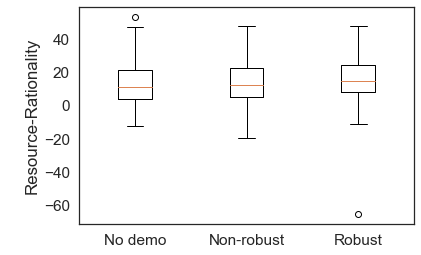

In [316]:
def rem_quantile(d, q=0.05):
    assert q <= 0.5
    low = np.quantile(d, q)
    high = np.quantile(d, 1-q)
    return [k for k in d if k <= high and k >= low]

#mod_mean = [rem_quantile(d, q=0.05) for d in ds[0]]
mod_mean = [d for d in ds[0]]

plt.boxplot(mod_mean, labels=conds);
plt.ylabel("\nResource-Rationality")
plt.savefig("box_plot.pdf", bbox_inches='tight')

### LM model

In [317]:
long_df['mean_score'] = long_df['score'] - long_df.groupby(['pid'])['score'].transform('mean')
long_df['mean_max_prob'] = long_df['max_prob'] - long_df.groupby(['pid'])['max_prob'].transform('mean')
long_df['mean_max_ev'] = long_df['max_ev'] - long_df.groupby(['pid'])['max_ev'].transform('mean')
long_df['mean_max_ev_pos'] = long_df['max_ev_pos'] - long_df.groupby(['pid'])['max_ev_pos'].transform('mean')
for i in range(7):
    long_df[f'mean_ev_{i}'] = long_df[f'ev_{i}'] - long_df.groupby(['pid'])[f'ev_{i}'].transform('mean')

In [319]:
print(long_df)

      pid  trial_id environment  condition  score  max_prob  max_ev  \
0       0         0      high_1          0     25      0.81   35.05   
1       0         1      high_1          0     88      1.00   99.00   
2       0         2      high_1          0     -3      0.52   29.21   
3       0         3      high_1          0     33      0.96   41.92   
4       0         4      high_1          0     17      1.00   26.00   
...   ...       ...         ...        ...    ...       ...     ...   
4795  479         5      high_2          0     10      0.82   29.14   
4796  479         6      high_2          0      0      0.56   16.68   
4797  479         7      high_2          0     13      0.97   34.68   
4798  479         8      high_2          0    -28      0.45   44.38   
4799  479         9      high_2          0     -1      0.59   16.58   

      max_ev_pos  rank_ev                                      payoff_matrix  \
0              6        2  [[-3, 19, 16, 15, 37, -65, 4], [28, 22, 

In [320]:
long_df.to_csv("stats.csv")

In [321]:
print(long_df['robust'].unique())

[False  True]


In [220]:
set_ev_vars = False

long_df["pid"] = "P" + long_df["pid"].astype(str)
ev_vars = [f"mean_ev_{i}" for i in range(7)]
dep_var = 'score' #'rank_ev'
indep_vars = ['high_2', 'robust', 'non_robust', 'high_2*robust', 'high_2*non_robust']
                #"mean_max_prob", 
                #"trial_id", "mean_max_ev_pos"]
#re_vars = ["mean_max_prob", "trial_id", "mean_max_ev_pos"]
total_indep_vars = indep_vars
if set_ev_vars:
    total_indep_vars += ev_vars
    re_vars += ev_vars
model_str = dep_var + " ~ " + " + ".join(total_indep_vars)
#re_str = " + ".join(re_vars)

print("Model str:", model_str)
print("Re str:", re_str)

Model str: score ~ high_2 + robust + non_robust + high_2*robust + high_2*non_robust
Re str: mean_max_prob + trial_id + mean_max_ev_pos


In [222]:
l_df = long_df[~(long_df.condition == 0)]
indep_vars = ['high_2', 'robust', 'high_2*robust']
model_str = dep_var + " ~ " + " + ".join(total_indep_vars)

model = smf.mixedlm(model_str, l_df)
model_fit = model.fit()
print("Params:\n", model_fit.params, "\n")
print("Convergence:", model_fit.converged, "\n")
print("Summary:\n", model_fit.summary())

AttributeError: 'groups' is a required keyword argument in MixedLM.from_formula

### Test for significance of robust vs non-robust

In [207]:
print(model_fit.wald_test([0, 0, 1, -1] + [0]*(len(model_fit.params) - 4)))

<Wald test (chi2): statistic=[[4.88355496]], p-value=0.027113721868308745, df_denom=1>


/Users/yjain/anaconda3/envs/cogtut/lib/python3.7/site-packages/statsmodels/base/model.py:1894: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  FutureWarning


### Seeing if first trial scores are very different from all other trials

In [ ]:
ev_scores = long_df.groupby('trial_id')
from scipy.stats import shapiro

f_s = long_df[long_df.trial_id == 0]['score']
s_s = long_df[~(long_df.trial_id == 0)]['score']

from scipy.stats import mannwhitneyu as ranksums
s, p = shapiro(f_s)
print(np.round(s, 2), np.round(p, 4))

s, p = shapiro(s_s)
print(np.round(s, 2), np.round(p, 4))

# ranksums
st, p = ranksums(f_s, s_s)
print(np.round(st, 2), np.round(p, 4))

### Statistics on number of clicks

In [ ]:
c = 'clicks'
no_demo_clicks = add_l(no_demo_df[c].values)
non_robust_clicks = add_l(non_robust_df[c].values)
robust_clicks = add_l(robust_df[c].values)

# No demo
s, p = shapiro(no_demo_clicks)
print(np.round(s, 2), np.round(p, 4))

# Non-robust
s, p = shapiro(non_robust_clicks)
print(np.round(s, 2), np.round(p, 4))

# Robust
s, p = shapiro(robust_clicks)
print(np.round(s, 2), np.round(p, 4))

print(np.mean(no_demo_clicks), np.mean(non_robust_clicks), np.mean(robust_clicks))

from scipy.stats import mannwhitneyu
# No-demo vs Non-robust
st, p = mannwhitneyu(no_demo_clicks, non_robust_clicks)
print(np.round(st, 2), np.round(p, 4))
# No-demo vs Robust
st, p = mannwhitneyu(no_demo_clicks, robust_clicks)
print(np.round(st, 2), np.round(p, 4))
# Non-robust vs Robust
st, p = mannwhitneyu(non_robust_clicks, robust_clicks)
print(np.round(st, 2), np.round(p, 4))